**Unzip the uploaded data files**

In [1]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# End-to-end multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.5.0 and TensorFlow Hub.

## 1. Problem
Identifing the breed of dog using a given image of the dog.
When I'm sitting in a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data that we are using is from Kaggle's Dog Breed Identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data), so it's probably best we use Deep Learning / Transfer Learning.
* There are 120 breeds of dogs (This means there are 120 different classes.
* There are around 10,000+ images in the training set (These images have labels).
* There around 10,000+ images in the test set (these images will have no labels, because we want to predict them).



# Get our workspace ready

* Import TensorFLow
* Import TensorFlow Hub
* Make sure we'e using a GPU

In [2]:
# Import TensorFlow in Colab
import tensorflow as tf
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TensorFlow Hub Version: " + hub.__version__)

TensorFlow Hub Version: 0.12.0


In [4]:
# Check for GPU availability
# https://research.google.com/colaboratory/faq.html#gpu-availability
print("GPU", " available (YESS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU  available (YESS!!!!!)


In [5]:
# Change Runtime Type to GPU
# Go to Runtime -> Chage Runtime Type -> Select GPU and save

## Getting our data read (turning it into tensors)

With all machine learning models our data has to be in numerical format. So that's what we'll be doing first. Turning our images into tensors (numerical representations).

Let's start by accessing our data and checking out the labes.

In [6]:
# Check out the labels of our data
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     767bddefbcbc83a67444bfc76ff42660  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


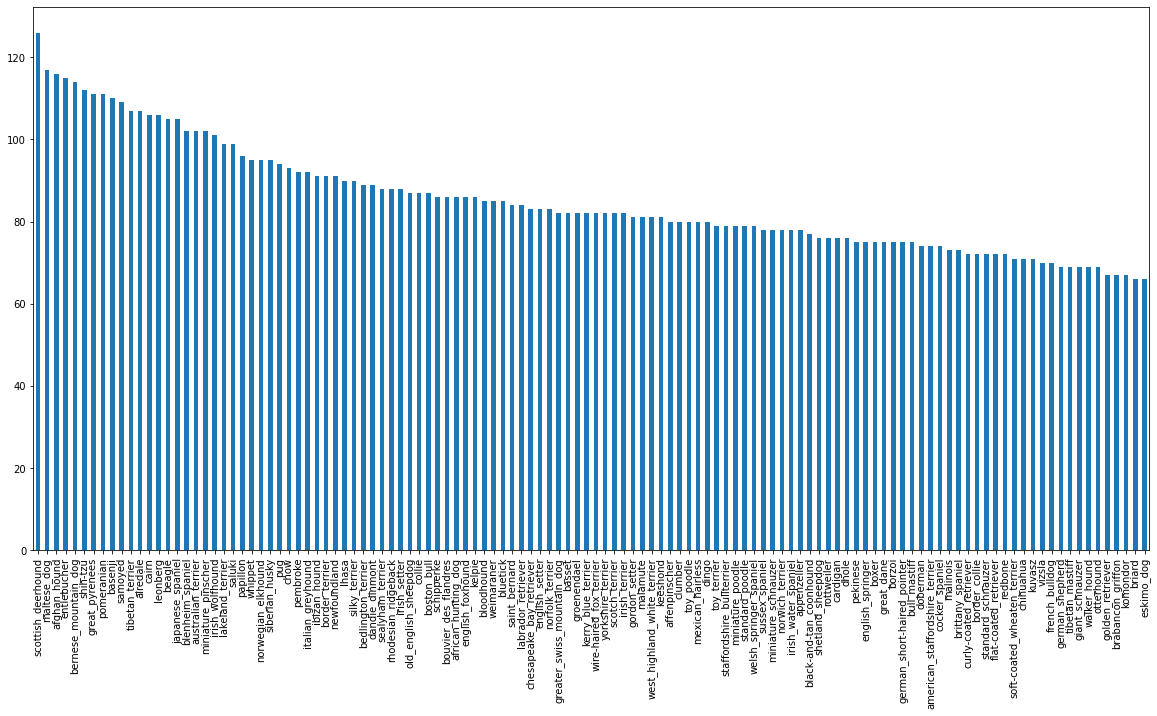

In [7]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [8]:
# Check the median
labels_csv["breed"].value_counts().median() 

82.0

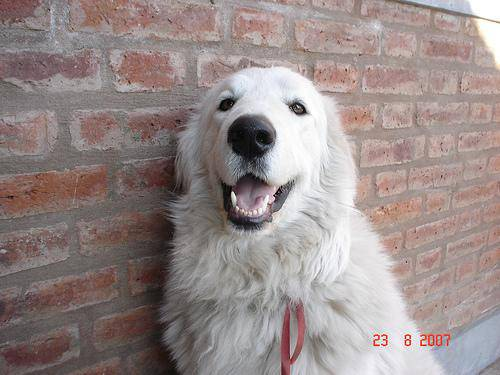

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0a0c223352985ec154fd604d7ddceabd.jpg")

### Getting images and their labels

Let's get a list of all of our images pathnames.

In [10]:
# Create pathnames from images ID's in labels_csv data frame
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match the actual amount of files!!! Procceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match the actual amount of files!!! Procceed.


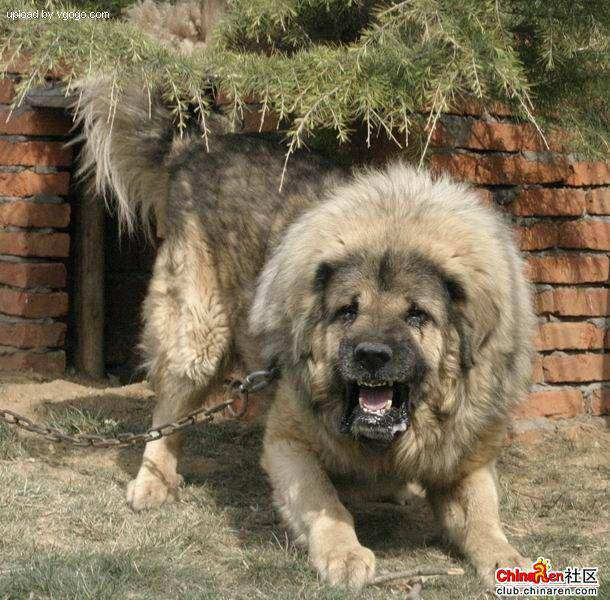

In [12]:
# View some random index image
Image(filenames[9000])

In [13]:
# Check the breed of dog at 9000 index
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training images filepaths in a list, let's prepare our labels

In [14]:
labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches with number of filenames!!")
else:
  print("Number of labels doesn't match with number of filenames. Check data directories")

Number of labels matches with number of filenames!!


In [19]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [20]:
len(unique_breeds)

120

In [21]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Turning boolean array in intergers
print(labels[0]) # Origin
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
